In [1]:
import os
os.listdir('../data')
TEST_PATH = "../data/test.csv"
TRAIN_PATH = "../data/train.csv"
SAMPLE_SUBMISSION_PATH = "../data/sample_submission.csv"

In [2]:
import pandas as pd
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)
sample_submission_data = pd.read_csv(SAMPLE_SUBMISSION_PATH)

In [3]:
prediction_columns = [col for col in train_data.columns if col not in test_data]
input_columns = [col for col in test_data.columns]
print(prediction_columns)
print(input_columns)

['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']
['qa_id', 'question_title', 'question_body', 'question_user_name', 'question_user_page', 'answer', 'answer_user_name', 'answer_user_page', 'url', 'category', 

In [4]:
X, y = train_data[input_columns], train_data[prediction_columns]

# BERT

In [27]:
X = pd.read_csv('../data/bert_features.csv')
X = X.iloc[:, 1:]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [29]:
X_train.shape

(4559, 2304)

In [30]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred = pd.DataFrame(y_pred)

In [31]:
# evaluation
import math
from scipy import stats
def evaluate(y_test, y_pred):
    assert y_test.shape == y_pred.shape
    correlations = [stats.spearmanr(y_test.iloc[:, col_index], y_pred.iloc[:, col_index]).correlation for col_index in range(y_test.shape[1])]
    score = sum([*filter(lambda x: not math.isnan(x), correlations)]) / len([*filter(lambda x: not math.isnan(x), correlations)])
    return score, correlations

In [32]:
score, correlations = evaluate(y_test, y_pred)
score

0.22634422484181108

# NN

In [109]:
BATCH_SIZE = 5
LOSS = nn.MSELoss()
EPOCHS = 8

In [110]:
X_train.shape, y_train.shape

((4559, 2304), (4559, 30))

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(768 * 3, 768)
        self.fc2 = nn.Linear(768, 256)
        self.fc3 = nn.Linear(256, 30)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [112]:
def get_batch(df, i, batch_size=BATCH_SIZE):
    return torch.Tensor(df.iloc[i:i+batch_size,:].values)

def get_test_loss(X_test, y_test):
    test_rounds = int(X_test.shape[0] / BATCH_SIZE)
    running_test_loss = 0.0
    for j in range(test_rounds):
        inputs = get_batch(X_test, j)
        outputs = net(inputs)
        labels = get_batch(y_test, j)
        loss = LOSS(outputs, labels)
        running_test_loss += loss
    running_test_loss /= test_rounds
    return running_test_loss


def train(net, X, y, X_test, y_test, optimizer):
    train_loss, test_loss = [], []
    rounds = int(X.shape[0] / BATCH_SIZE)   
    loss_round = int(X.shape[0] / 10)
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        for i in range(rounds):
            inputs = get_batch(X, i)
            optimizer.zero_grad()
            
            outputs = net(inputs)
            labels = get_batch(y, i)
            loss = LOSS(outputs, labels)
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            if i % loss_round == loss_round - 1:
                
                running_loss /= loss_round
                running_test_loss = get_test_loss(X_test, y_test)
                
                train_loss.append(running_loss)
                test_loss.append(running_test_loss)
                print('[%d, %5d] train_loss: %.3f, test_loss: %.3f' %
                  (epoch + 1, i + 1, running_loss, running_test_loss))
                running_loss = 0.0
                
                
    return train_loss, test_loss

In [113]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
losses = train(net, X_train, y_train, X_test, y_test, optimizer)

[1,   455] train_loss: 0.089, test_loss: 0.061
[1,   910] train_loss: 0.062, test_loss: 0.058
[2,   455] train_loss: 0.059, test_loss: 0.058
[2,   910] train_loss: 0.058, test_loss: 0.055
[3,   455] train_loss: 0.056, test_loss: 0.055
[3,   910] train_loss: 0.055, test_loss: 0.053
[4,   455] train_loss: 0.054, test_loss: 0.054
[4,   910] train_loss: 0.053, test_loss: 0.052
[5,   455] train_loss: 0.053, test_loss: 0.053
[5,   910] train_loss: 0.052, test_loss: 0.051
[6,   455] train_loss: 0.052, test_loss: 0.052
[6,   910] train_loss: 0.051, test_loss: 0.051
[7,   455] train_loss: 0.051, test_loss: 0.052
[7,   910] train_loss: 0.050, test_loss: 0.050
[8,   455] train_loss: 0.050, test_loss: 0.051
[8,   910] train_loss: 0.049, test_loss: 0.050


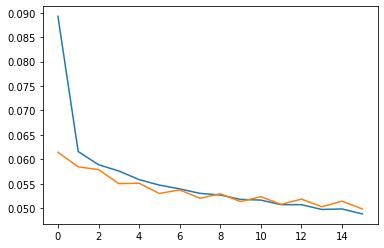

In [114]:
from matplotlib import pyplot as plt
plt.plot(losses[0])
plt.plot(losses[1])

In [129]:
y_pred = net(get_batch(X_test, 0, batch_size=X_test.shape[0]))
y_pred = pd.DataFrame(y_pred.detach().numpy())

In [130]:
y_test.shape, y_pred.shape

((1520, 30), (1520, 30))

In [132]:
score, correlations = evaluate(y_test, y_pred)
score

0.2659160845930362